In [46]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split,cross_val_score, KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
IMAGE_SIZE = (128, 128)
NUM_CLASSES = 2

In [7]:
DATA_DIR = r'C:\Users\geeth\Downloads\test_data\YOLO-Object-Detection\DL project\Data'

In [8]:
DEFECTIVE_DIR = os.path.join(DATA_DIR, 'Defective_cubes')
QUALITY_DIR = os.path.join(DATA_DIR, 'Quality_cubes')

In [9]:
def load_data(directory):
    images = []
    labels = []
    label = 0 if directory == QUALITY_DIR else 1 
    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [10]:
defective_images, defective_labels = load_data(DEFECTIVE_DIR)
quality_images, quality_labels = load_data(QUALITY_DIR)

In [11]:
cube_images = np.concatenate([defective_images, quality_images], axis=0)

In [12]:
cube_labels = np.concatenate([defective_labels, quality_labels], axis=0)

In [13]:
train_images, test_images,train_labels, test_labels = train_test_split(cube_images, cube_labels, test_size=0.2, random_state=42)

In [14]:
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

In [15]:
print("Shape of train_images_normalized:", train_images_normalized.shape)
print("Shape of train_labels:", train_labels.shape)


Shape of train_images_normalized: (3579, 128, 128, 3)
Shape of train_labels: (3579,)


In [16]:
n_samples, width, height, channels = train_images_normalized.shape
train_images_flattened = train_images_normalized.reshape((n_samples, width * height * channels))


In [28]:
rf_classifier = RandomForestClassifier()

In [34]:
param_distributions = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5,],
    'min_samples_leaf': [1, 2]
}

In [30]:
def flatten_images(images):
    n_samples, width, height, channels = images.shape
    return images.reshape((n_samples, width * height * channels))

In [35]:
random_search = RandomizedSearchCV(rf_classifier, param_distributions, n_iter=2, cv=2, random_state=42)


In [36]:
random_search.fit(train_images_normalized.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3), train_labels)


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=2,
                   param_distributions={'max_depth': [None, 10],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 150]},
                   random_state=42)

In [37]:
best_params = random_search.best_params_

In [39]:
print(best_params)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [40]:
best_rf_classifier = RandomForestClassifier(**best_params)

In [41]:
best_rf_classifier.fit(train_images_normalized.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3), train_labels)


RandomForestClassifier(n_estimators=150)

In [50]:
n_samples, width, height, channels = test_images_normalized.shape
test_images_flattened = test_images_normalized.reshape((n_samples, width * height * channels))

In [43]:
train_predictions = best_rf_classifier.predict(train_images_normalized.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3))

In [51]:
accuracy = best_rf_classifier.score(test_images_flattened, test_labels)


In [52]:
accuracy

0.9106145251396648

In [53]:
predictions = best_rf_classifier.predict(test_images_flattened)


In [54]:
recall = recall_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
f1= f1_score(test_labels, predictions)

In [55]:
print(" Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print(f'Test Accuracy: {accuracy}')

 Recall: 0.8926940639269406
Precision: 0.9221698113207547
F1 Score: 0.9071925754060324
Test Accuracy: 0.9106145251396648


In [56]:
conf_matrix = tf.math.confusion_matrix(test_labels, predictions)


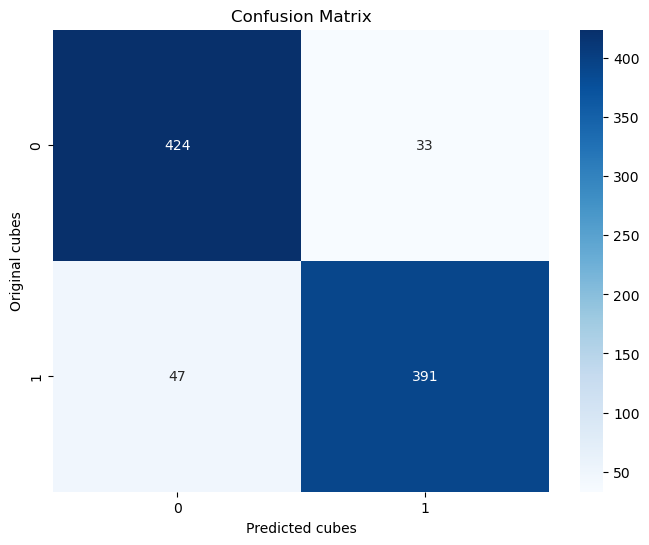

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted cubes')
plt.ylabel('Original cubes')
plt.title('Confusion Matrix')
plt.show()

In [58]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(test_labels, predictions, target_names=["Quality", "Defective"], output_dict=True)
precision_quality = report["Quality"]["precision"]
precision_defective = report["Defective"]["precision"]
recall_quality = report["Quality"]["recall"]
recall_defective = report["Defective"]["recall"]
f1_score_quality = report["Quality"]["f1-score"]
f1_score_defective = report["Defective"]["f1-score"]


In [59]:
conf_matrix_df = pd.DataFrame(conf_matrix.numpy(), index=["Quality", "Defective"], columns=["Quality", "Defective"])

In [60]:
precision_quality = conf_matrix_df.loc["Quality", "Quality"] / conf_matrix_df["Quality"].sum()
precision_defective = conf_matrix_df.loc["Defective", "Defective"] / conf_matrix_df["Defective"].sum()
recall_quality = conf_matrix_df.loc["Quality", "Quality"] / conf_matrix_df.loc["Quality"].sum()
recall_defective = conf_matrix_df.loc["Defective", "Defective"] / conf_matrix_df.loc["Defective"].sum()

In [61]:
print("Precision (Quality):", precision_quality)
print("Recall (Quality):", recall_quality)
print("F1-Score (Quality):", f1_score_quality)
print("Precision (Defective):", precision_defective)
print("Recall (Defective):", recall_defective)
print("F1-Score (Defective):", f1_score_defective)

Precision (Quality): 0.9002123142250531
Recall (Quality): 0.9277899343544858
F1-Score (Quality): 0.9137931034482758
Precision (Defective): 0.9221698113207547
Recall (Defective): 0.8926940639269406
F1-Score (Defective): 0.9071925754060324


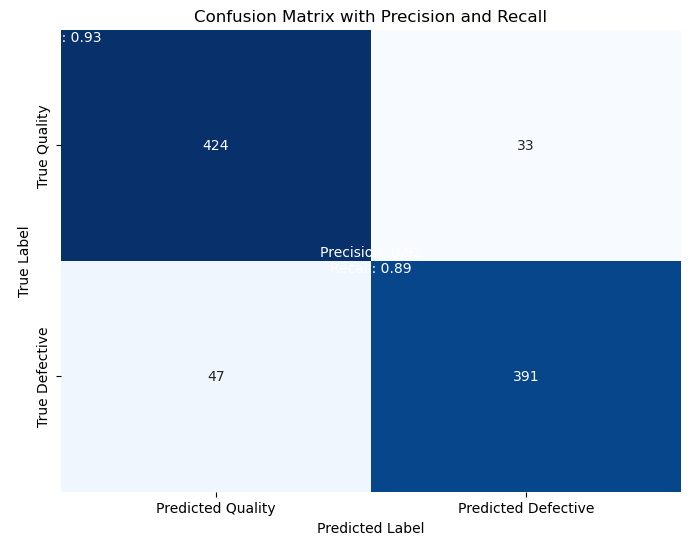

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Quality', 'Predicted Defective'],
            yticklabels=['True Quality', 'True Defective'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Precision and Recall')
plt.text(0, 0, f'Precision: {precision_quality:.2f}\nRecall: {recall_quality:.2f}', ha="center", va="center", color="white")
plt.text(1, 1, f'Precision: {precision_defective:.2f}\nRecall: {recall_defective:.2f}', ha="center", va="center", color="white")
plt.show()